In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [112]:
import tensorflow as tf
from tensorflow import keras
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoConfig
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm_notebook
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q

from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
sns.set()

In [24]:
%%time
judgments = pd.read_csv('Data/tira-qrels', delim_whitespace=True, names=['topic','iteration','id','relevance'])
arguments = pd.read_pickle('Data/dataset.pkl')

tree = ET.parse('Data/topics-automatic-runs-task-1.xml')
root = tree.getroot()

topics = []
for child in root:
    d = {'topic':int(child[0].text), 'query':child[1].text}
    topics.append(d)
topics = pd.DataFrame(topics)

relevance = judgments.merge(topics)
relevance['relevance_binary'] = (relevance['relevance'] != -2).astype(int)
relevance = relevance.merge(arguments[['id', 'text', 'conclusion']])
relevance = relevance[['id', 'query', 'text', 'conclusion', 'relevance','relevance_binary']]
relevance = relevance.sample(frac=1, random_state=42)
relevance.reset_index(inplace=True)
display(topics[:5])
display(relevance[:5])

,topic,query
0,1,Should Teachers Get Tenure?
1,2,Is Vaping with E-Cigarettes Safe?
2,3,Should Insider Trading Be Allowed?
3,4,Should Corporal Punishment Be Used in Schools?
4,5,Should Social Security Be Privatized?


,index,id,query,text,conclusion,relevance,relevance_binary
0,353,d267a5af-2019-04-18T18:07:23Z-00009-000,Should Marijuana Be a Medical Option?,Marijuana is a major concern to the United Sta...,Medical Marijuana,3,1
1,864,7839a8e-2019-04-18T13:02:10Z-00000-000,Is Sexual Orientation Determined at Birth?,Why did you accept my debate if you agreed wit...,Sexual Orientation is a choice.,-2,0
2,1312,e100392e-2019-04-18T19:19:21Z-00000-000,Do Standardized Tests Improve Education?,"You don't it, you have to provide PROOF you di...",Cannabis Sativa Enhances my Life,-2,0
3,192,5339b784-2019-04-18T15:45:56Z-00005-000,Should the Federal Minimum Wage Be Increased?,I accept this challenge and negate the resolut...,Resolved: Minimum wages in the United States s...,2,1
4,782,61bcba6c-2019-04-18T15:04:19Z-00004-000,Should Animals Be Used for Scientific or Comme...,"Well, first of all, thanks for accepting.-----...",Animal Testing,3,1


CPU times: user 896 ms, sys: 381 ms, total: 1.28 s
Wall time: 1.27 s


In [5]:
def make_dataset_for_encoding(df, batch_size=128):
    df = df.copy()
    dataset = tf.data.Dataset.from_tensor_slices(dict(df[['query','text','conclusion']]))
    dataset = dataset.batch(batch_size)
    return dataset

# With Huggingface

In [5]:
MODEL_TO_USE = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_TO_USE, use_fast=True)

In [6]:
%%time
tokenized = []
for chunk in tqdm_notebook(np.array_split(relevance, 1), total=1):
    tokenized_chunk = tokenizer.batch_encode_plus(list(zip(list(chunk['query'].values), list(chunk['text'].values))), max_length=tokenizer.max_len, pad_to_max_length=True, return_overflowing_tokens=True)
    tokenized_chunk.pop('token_type_ids')

    overflow_index = tokenized_chunk.pop('overflow_to_sample_mapping')

    # Repeating indices are included as lists of the corresponding index eg: [0,1, [2,2,2,2], [3,3]...]
    overflow_index = np.hstack(overflow_index)
    text_ids = chunk['id'].values
    text_ids = text_ids[overflow_index]
    
    old_index = chunk.index.to_series().values
    old_index = old_index[overflow_index]
    
    relevance_score = chunk['relevance'].values
    relevance_score = relevance_score[overflow_index]
    
    binary_score = chunk['relevance_binary'].values
    binary_score = binary_score[overflow_index]

    df = pd.DataFrame(tokenized_chunk)
    df[['input_ids', 'attention_mask']] = df[['input_ids', 'attention_mask']].applymap(np.array)
    df['id'] = text_ids
    df['old_index'] = old_index
    df['relevance_score'] = relevance_score
    df['binary_score'] = binary_score
    tokenized.append(df)
tokenized = pd.concat(tokenized)
tokenized.reset_index(inplace=True, drop=True)
tokenized[:3]


CPU times: user 2.4 s, sys: 452 ms, total: 2.85 s
Wall time: 693 ms


,input_ids,attention_mask,id,old_index,relevance_score,binary_score
0,"[101, 2323, 16204, 2022, 1037, 2966, 5724, 102...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",d267a5af-2019-04-18T18:07:23Z-00009-000,353,3,1
1,"[101, 2003, 4424, 10296, 4340, 2012, 4182, 102...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",7839a8e-2019-04-18T13:02:10Z-00000-000,864,-2,0
2,"[101, 2079, 16367, 5852, 5335, 2495, 1029, 102...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",e100392e-2019-04-18T19:19:21Z-00000-000,1312,-2,0


In [7]:
tokenized_train, tokenized_valid = train_test_split(tokenized, shuffle=False, random_state=42, train_size=0.85)

In [8]:
config = AutoConfig.from_pretrained(MODEL_TO_USE)
config.num_labels=2
seq_model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_TO_USE, config=config)

In [20]:
i_train = np.stack(tokenized_train['input_ids'])
m_train = np.stack(tokenized_train['attention_mask'])
relevance_train = np.stack(tokenized_train['relevance_score'].values)
binary_train = np.stack(tokenized_train['binary_score'].values)

i_valid = np.stack(tokenized_valid['input_ids'])
m_valid = np.stack(tokenized_valid['attention_mask'])
relevance_valid = np.stack(tokenized_valid['relevance_score'].values)
binary_valid = np.stack(tokenized_valid['binary_score'].values)

In [16]:
i_train.shape

(1218, 512)

## Define a multiple input - multiple output keras neural network using the functional API, with a huggingface sequence classifier with two outputs

In [59]:
keras.backend.clear_session()

input_ids = keras.layers.Input(shape=[512], name="input_ids", dtype=tf.int64)
input_masks = keras.layers.Input(shape=[512], name="masks", dtype=tf.int64)
seq_model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_TO_USE, config=config)
two_outputs = seq_model(input_ids, attention_mask=input_masks, training=True)[0]
output_relevance = keras.layers.Lambda(lambda x: x[:,0], name="relevance_regressor")(two_outputs)
output_binary = keras.layers.Lambda(lambda x: x[:,1])(two_outputs)
output_binary = keras.layers.Activation('sigmoid', name="binary_relevance_classifier")(output_binary)
model = keras.Model(inputs=[input_ids, input_masks], outputs=[output_relevance, output_binary])


model.compile(loss=["mse", keras.losses.BinaryCrossentropy(from_logits=True)], loss_weights=[0.85, 0.15], optimizer="Adam")
callback_list = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)]

In [61]:
hist = model.fit([i_train, m_train], [relevance_train, binary_train], batch_size=32, epochs=50, validation_data=([i_valid, m_valid],[relevance_valid, binary_valid]), callbacks=callback_list)

Train on 1218 samples, validate on 216 samples
Epoch 1/50
1218/1218 [==============================] - 28s 23ms/sample - loss: 3.7713 - relevance_regressor_loss: 4.2686 - binary_relevance_classifier_loss: 0.5349 - val_loss: 3.4723 - val_relevance_regressor_loss: 4.0271 - val_binary_relevance_classifier_loss: 0.5060
Epoch 2/50
1218/1218 [==============================] - 27s 22ms/sample - loss: 3.4578 - relevance_regressor_loss: 3.9168 - binary_relevance_classifier_loss: 0.5227 - val_loss: 3.2226 - val_relevance_regressor_loss: 3.7355 - val_binary_relevance_classifier_loss: 0.5077
Epoch 3/50
1218/1218 [==============================] - 27s 22ms/sample - loss: 3.4161 - relevance_regressor_loss: 3.8552 - binary_relevance_classifier_loss: 0.5195 - val_loss: 3.2008 - val_relevance_regressor_loss: 3.7097 - val_binary_relevance_classifier_loss: 0.5066
Epoch 4/50
1218/1218 [==============================] - 27s 23ms/sample - loss: 3.3217 - relevance_regressor_loss: 3.7637 - binary_relevance_cl

KeyboardInterrupt: 

In [56]:
model.predict([i_train[:3], m_train[:3]])

[array([1.5302646, 1.6240828, 1.5198188], dtype=float32),
 array([0.99761826, 0.99823296, 0.9982457 ], dtype=float32)]

# With TF-Hub

In [4]:
%%time
keras.backend.clear_session()

module = hub.load('https://tfhub.dev/google/universal-sentence-encoder-qa/3')
query_embedder = module.signatures['question_encoder']
arg_embedder = module.signatures['response_encoder']

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-qa/3'.
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder-qa/3: 170.04MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder-qa/3: 340.04MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder-qa/3: 510.04MB
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder-qa/3, Total size: 588.94MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-qa/3'.


CPU times: user 31.2 s, sys: 5.8 s, total: 37 s
Wall time: 1min 13s


In [67]:
dataset = make_dataset_for_encoding(relevance, batch_size=32)

query_encodings = []
arg_encodings = []
dot_ps = []
for batch in tqdm_notebook(dataset, total=tf.data.experimental.cardinality(dataset).numpy()):
    query_encoding = query_embedder(batch['query'])
    query_encoding = query_encoding['outputs'].numpy()
    
    arg_encoding = arg_embedder(input=batch['text'], context=batch['conclusion'])
    arg_encoding = arg_encoding['outputs'].numpy()
    
    #Use einstein notation to perform row-by-row dot-product
    dot_p = np.einsum('ij,ij->i',query_encoding, arg_encoding)
    
    query_encodings.append(query_encoding)
    arg_encodings.append(arg_encoding)
    dot_ps.append(dot_p)
query_encodings = np.vstack(query_encodings)
arg_encodings = np.vstack(arg_encodings)
encodings = np.hstack([query_encodings, arg_encodings])

#Add a column dimension to dot_ps to be able to vstack it
dot_ps = np.vstack([item[:, np.newaxis] for item in dot_ps])

## Create a *Wide and Deep* network to predict relevance from a query and an argument

The wide network will use the elasticsearch LMDirichlet scores and the dot-product of the query embedding and argument embedding returned by the Universal Sentence Encoder for question-answering

In [11]:
es = Elasticsearch()
es.ping()

True

In [68]:
relevance

,index,id,query,text,conclusion,relevance,relevance_binary
0,353,d267a5af-2019-04-18T18:07:23Z-00009-000,Should Marijuana Be a Medical Option?,Marijuana is a major concern to the United Sta...,Medical Marijuana,3,1
1,864,7839a8e-2019-04-18T13:02:10Z-00000-000,Is Sexual Orientation Determined at Birth?,Why did you accept my debate if you agreed wit...,Sexual Orientation is a choice.,-2,0
2,1312,e100392e-2019-04-18T19:19:21Z-00000-000,Do Standardized Tests Improve Education?,"You don't it, you have to provide PROOF you di...",Cannabis Sativa Enhances my Life,-2,0
3,192,5339b784-2019-04-18T15:45:56Z-00005-000,Should the Federal Minimum Wage Be Increased?,I accept this challenge and negate the resolut...,Resolved: Minimum wages in the United States s...,2,1
4,782,61bcba6c-2019-04-18T15:04:19Z-00004-000,Should Animals Be Used for Scientific or Comme...,"Well, first of all, thanks for accepting.-----...",Animal Testing,3,1
...,...,...,...,...,...,...,...
1406,1095,36f68365-2019-04-18T15:05:04Z-00000-000,Do Electronic Voting Machines Improve the Voti...,"As you can see, my opponent has failed to back...",Earth's orbit around the Sun,-2,0
1407,1130,2c05e9fb-2019-04-15T20:23:05Z-00005-000,Do Electronic Voting Machines Improve the Voti...,Remote electronic voting can be conducted very...,allow the use of electronic and internet votin...,-2,0
1408,1294,b760077b-2019-04-18T13:01:46Z-00003-000,Do Standardized Tests Improve Education?,"Challenge accepted, Standardized tests should ...",Standardized Tests,3,1
1409,860,b9c0e12b-2019-04-18T13:51:22Z-00005-000,Is Sexual Orientation Determined at Birth?,Lol well that was a waste of a round. But I gu...,there is nothing wrong with zoosexuality/beast...,3,1


In [79]:
relevance.text.str.len().values[:, np.newaxis].shape

(1411, 1)

## Compute Dirichlet scores for every query-argument in the judgments

In [70]:
%%time
dirichlet_scores = np.zeros(dot_ps.shape)
for i, row in relevance.iterrows():
    s = Search(using=es, index='arg_index')
    s.query = Q("match", text=row['query']) & Q("term", _id=row['id'])
    response = s.execute()
    if not response.hits.total.value == 0:
        dirichlet_scores[i,0] = response[0].meta.score

CPU times: user 3.26 s, sys: 105 ms, total: 3.36 s
Wall time: 6.86 s


In [71]:
np.sum(dirichlet_scores == 0)

167

In [72]:
np.sum((relevance.relevance == -2).values)

295

## Create network with the tf.keras functional API

In [82]:
wide_i = np.hstack([dot_ps, dirichlet_scores, relevance.text.str.len().values[:, np.newaxis]])
deep_i = encodings

In [105]:
targets = relevance[["relevance", "relevance_binary"]].values

In [106]:
targets

array([[ 3,  1],
       [-2,  0],
       [-2,  0],
       ...,
       [ 3,  1],
       [ 3,  1],
       [-2,  0]])

In [93]:
#From Aurelien Geron's HOML https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch11.html
RegularizedDense = partial(keras.layers.Dense, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2())

In [94]:
keras.backend.clear_session()

input_wide = keras.layers.Input(shape=[3], name="wide")
input_deep = keras.layers.Input(shape=[1024], name="deep")

norm_input_deep = keras.layers.BatchNormalization()(input_deep)

hidden1 = RegularizedDense(1024)(norm_input_deep)
hidden1 = keras.layers.BatchNormalization()(hidden1)

hidden2 = RegularizedDense(512)(hidden1)
hidden2 = keras.layers.BatchNormalization()(hidden2)

hidden3 = RegularizedDense(64)(hidden2)
hidden3 = keras.layers.BatchNormalization()(hidden3)

hidden4 = RegularizedDense(2)(hidden3)

concat = keras.layers.concatenate([input_wide, hidden4])

mix = RegularizedDense(8)(concat)

output_reg = keras.layers.Dense(1, name="output_reg")(mix)
output_class = keras.layers.Dense(1, activation="sigmoid", name="output_class")(mix)
output_aux = keras.layers.Dense(1, activation="sigmoid", name="output_aux")(hidden4)

wide_and_deep = keras.Model(inputs=[input_wide, input_deep], outputs=[output_reg, output_class, output_aux])

In [104]:
wide_and_deep.compile(loss=["mse", keras.losses.BinaryCrossentropy(from_logits=True), keras.losses.BinaryCrossentropy(from_logits=True)], loss_weights=[0.7, 0.15, 0.15], optimizer="rmsprop")

In [110]:
hist = wide_and_deep.fit([wide_i, deep_i], [targets[:,0], targets[:,1], targets[:,1]], batch_size=64, epochs=500, callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5)])

Train on 1411 samples
Epoch 1/500
1411/1411 [==============================] - 0s 202us/sample - loss: 3.9726 - output_reg_loss: 4.5035 - output_class_loss: 0.5137 - output_aux_loss: 0.4357
Epoch 2/500
1411/1411 [==============================] - 0s 227us/sample - loss: 2.4136 - output_reg_loss: 2.9519 - output_class_loss: 0.5137 - output_aux_loss: 0.4366
Epoch 3/500
1411/1411 [==============================] - 0s 233us/sample - loss: 3.7988 - output_reg_loss: 4.0215 - output_class_loss: 0.5275 - output_aux_loss: 0.4404
Epoch 4/500
1411/1411 [==============================] - 0s 232us/sample - loss: 3.6287 - output_reg_loss: 4.0855 - output_class_loss: 0.5137 - output_aux_loss: 0.4323
Epoch 5/500
1411/1411 [==============================] - 0s 240us/sample - loss: 3.3014 - output_reg_loss: 3.4667 - output_class_loss: 0.5275 - output_aux_loss: 0.4431
Epoch 6/500
1411/1411 [==============================] - 0s 239us/sample - loss: 4.0438 - output_reg_loss: 4.8254 - output_class_loss: 0.5

1411/1411 [==============================] - 0s 223us/sample - loss: 0.8434 - output_reg_loss: 0.4130 - output_class_loss: 0.5275 - output_aux_loss: 0.4137
Epoch 50/500
1411/1411 [==============================] - 0s 231us/sample - loss: 0.8527 - output_reg_loss: 0.6506 - output_class_loss: 0.5137 - output_aux_loss: 0.4128
Epoch 51/500
1411/1411 [==============================] - 0s 234us/sample - loss: 1.0387 - output_reg_loss: 0.9990 - output_class_loss: 0.5413 - output_aux_loss: 0.4310
Epoch 52/500
1411/1411 [==============================] - 0s 222us/sample - loss: 0.7948 - output_reg_loss: 0.3670 - output_class_loss: 0.5275 - output_aux_loss: 0.4181
Epoch 53/500
1411/1411 [==============================] - 0s 236us/sample - loss: 0.7650 - output_reg_loss: 0.5073 - output_class_loss: 0.5137 - output_aux_loss: 0.4135
Epoch 54/500
1411/1411 [==============================] - 0s 233us/sample - loss: 0.7564 - output_reg_loss: 0.3193 - output_class_loss: 0.5275 - output_aux_loss: 0.4125

1411/1411 [==============================] - 0s 234us/sample - loss: 0.7290 - output_reg_loss: 0.2776 - output_class_loss: 0.5275 - output_aux_loss: 0.4122
Epoch 98/500
1411/1411 [==============================] - 0s 234us/sample - loss: 0.7023 - output_reg_loss: 0.2381 - output_class_loss: 0.5275 - output_aux_loss: 0.4127
Epoch 99/500
1411/1411 [==============================] - 0s 234us/sample - loss: 0.7243 - output_reg_loss: 0.4723 - output_class_loss: 0.5137 - output_aux_loss: 0.4126
Epoch 100/500
1411/1411 [==============================] - 0s 232us/sample - loss: 0.7544 - output_reg_loss: 0.4751 - output_class_loss: 0.5137 - output_aux_loss: 0.4141
Epoch 101/500
1411/1411 [==============================] - 0s 234us/sample - loss: 0.7344 - output_reg_loss: 0.5872 - output_class_loss: 0.5137 - output_aux_loss: 0.4128
Epoch 102/500
1411/1411 [==============================] - 0s 236us/sample - loss: 0.7271 - output_reg_loss: 0.2706 - output_class_loss: 0.5137 - output_aux_loss: 0.4

1411/1411 [==============================] - 0s 235us/sample - loss: 0.7193 - output_reg_loss: 0.4652 - output_class_loss: 0.5137 - output_aux_loss: 0.4114
Epoch 146/500
1411/1411 [==============================] - 0s 240us/sample - loss: 0.7239 - output_reg_loss: 0.3769 - output_class_loss: 0.5275 - output_aux_loss: 0.4201
Epoch 147/500
1411/1411 [==============================] - 0s 239us/sample - loss: 0.7228 - output_reg_loss: 0.4087 - output_class_loss: 0.5413 - output_aux_loss: 0.4289
Epoch 148/500
1411/1411 [==============================] - 0s 239us/sample - loss: 0.7663 - output_reg_loss: 0.5177 - output_class_loss: 0.5137 - output_aux_loss: 0.4142
Epoch 149/500
1411/1411 [==============================] - 0s 235us/sample - loss: 0.7335 - output_reg_loss: 0.8815 - output_class_loss: 0.5551 - output_aux_loss: 0.4405
Epoch 150/500
1411/1411 [==============================] - 0s 239us/sample - loss: 0.7302 - output_reg_loss: 0.4420 - output_class_loss: 0.5137 - output_aux_loss: 0

1411/1411 [==============================] - 0s 239us/sample - loss: 0.7319 - output_reg_loss: 0.2799 - output_class_loss: 0.5137 - output_aux_loss: 0.4135
Epoch 194/500
1411/1411 [==============================] - 0s 236us/sample - loss: 0.7282 - output_reg_loss: 0.5227 - output_class_loss: 0.5137 - output_aux_loss: 0.4122
Epoch 195/500
1411/1411 [==============================] - 0s 236us/sample - loss: 0.7429 - output_reg_loss: 0.5175 - output_class_loss: 0.5137 - output_aux_loss: 0.4137
Epoch 196/500
1411/1411 [==============================] - 0s 234us/sample - loss: 0.7504 - output_reg_loss: 0.4283 - output_class_loss: 0.5275 - output_aux_loss: 0.4145
Epoch 197/500
1411/1411 [==============================] - 0s 234us/sample - loss: 0.7287 - output_reg_loss: 0.3679 - output_class_loss: 0.5413 - output_aux_loss: 0.4257
Epoch 198/500
1411/1411 [==============================] - 0s 235us/sample - loss: 0.7243 - output_reg_loss: 0.2977 - output_class_loss: 0.5275 - output_aux_loss: 0

1411/1411 [==============================] - 0s 240us/sample - loss: 0.7244 - output_reg_loss: 0.3092 - output_class_loss: 0.5137 - output_aux_loss: 0.4126
Epoch 242/500
1411/1411 [==============================] - 0s 231us/sample - loss: 0.7047 - output_reg_loss: 0.2436 - output_class_loss: 0.5137 - output_aux_loss: 0.4111
Epoch 243/500
1411/1411 [==============================] - 0s 242us/sample - loss: 0.7338 - output_reg_loss: 0.3765 - output_class_loss: 0.5137 - output_aux_loss: 0.4100
Epoch 244/500
1411/1411 [==============================] - 0s 201us/sample - loss: 0.7094 - output_reg_loss: 0.4039 - output_class_loss: 0.5413 - output_aux_loss: 0.4283
Epoch 245/500
1411/1411 [==============================] - 0s 208us/sample - loss: 0.7130 - output_reg_loss: 0.5679 - output_class_loss: 0.5137 - output_aux_loss: 0.4127
Epoch 246/500
1411/1411 [==============================] - 0s 234us/sample - loss: 0.7101 - output_reg_loss: 0.2707 - output_class_loss: 0.5137 - output_aux_loss: 0

1411/1411 [==============================] - 0s 231us/sample - loss: 0.7209 - output_reg_loss: 0.3995 - output_class_loss: 0.5137 - output_aux_loss: 0.4098
Epoch 290/500
1411/1411 [==============================] - 0s 228us/sample - loss: 0.7469 - output_reg_loss: 0.8011 - output_class_loss: 0.5275 - output_aux_loss: 0.4260
Epoch 291/500
1411/1411 [==============================] - 0s 221us/sample - loss: 0.7168 - output_reg_loss: 0.4425 - output_class_loss: 0.5137 - output_aux_loss: 0.4113
Epoch 292/500
1411/1411 [==============================] - 0s 207us/sample - loss: 0.7220 - output_reg_loss: 0.4645 - output_class_loss: 0.5275 - output_aux_loss: 0.4117
Epoch 293/500
1411/1411 [==============================] - 0s 229us/sample - loss: 0.7318 - output_reg_loss: 0.4417 - output_class_loss: 0.5137 - output_aux_loss: 0.4121
Epoch 294/500
1411/1411 [==============================] - 0s 234us/sample - loss: 0.7557 - output_reg_loss: 0.6129 - output_class_loss: 0.5137 - output_aux_loss: 0

1411/1411 [==============================] - 0s 232us/sample - loss: 0.7365 - output_reg_loss: 0.3196 - output_class_loss: 0.5137 - output_aux_loss: 0.4135
Epoch 338/500
1411/1411 [==============================] - 0s 239us/sample - loss: 0.7738 - output_reg_loss: 0.3819 - output_class_loss: 0.5413 - output_aux_loss: 0.4261
Epoch 339/500
1411/1411 [==============================] - 0s 237us/sample - loss: 0.7202 - output_reg_loss: 0.3687 - output_class_loss: 0.5137 - output_aux_loss: 0.4077
Epoch 340/500
1411/1411 [==============================] - 0s 239us/sample - loss: 0.7584 - output_reg_loss: 0.5283 - output_class_loss: 0.5137 - output_aux_loss: 0.4139
Epoch 341/500
1411/1411 [==============================] - 0s 236us/sample - loss: 0.7289 - output_reg_loss: 0.4462 - output_class_loss: 0.5137 - output_aux_loss: 0.4115
Epoch 342/500
1411/1411 [==============================] - 0s 236us/sample - loss: 0.7351 - output_reg_loss: 0.3896 - output_class_loss: 0.5413 - output_aux_loss: 0

1411/1411 [==============================] - 0s 230us/sample - loss: 0.7199 - output_reg_loss: 0.4070 - output_class_loss: 0.5413 - output_aux_loss: 0.4328
Epoch 386/500
1411/1411 [==============================] - 0s 238us/sample - loss: 0.7368 - output_reg_loss: 0.5264 - output_class_loss: 0.5137 - output_aux_loss: 0.4117
Epoch 387/500
1411/1411 [==============================] - 0s 236us/sample - loss: 0.7066 - output_reg_loss: 0.5468 - output_class_loss: 0.5137 - output_aux_loss: 0.4121
Epoch 388/500
1411/1411 [==============================] - 0s 236us/sample - loss: 0.7440 - output_reg_loss: 0.6196 - output_class_loss: 0.5413 - output_aux_loss: 0.4269
Epoch 389/500
1411/1411 [==============================] - 0s 237us/sample - loss: 0.7263 - output_reg_loss: 0.4337 - output_class_loss: 0.5137 - output_aux_loss: 0.4117
Epoch 390/500
1411/1411 [==============================] - 0s 241us/sample - loss: 0.7387 - output_reg_loss: 0.4547 - output_class_loss: 0.5137 - output_aux_loss: 0

1411/1411 [==============================] - 0s 236us/sample - loss: 0.7368 - output_reg_loss: 0.5865 - output_class_loss: 0.5137 - output_aux_loss: 0.4132
Epoch 434/500
1411/1411 [==============================] - 0s 239us/sample - loss: 0.7336 - output_reg_loss: 0.4870 - output_class_loss: 0.5137 - output_aux_loss: 0.4125
Epoch 435/500
1411/1411 [==============================] - 0s 238us/sample - loss: 0.7332 - output_reg_loss: 0.4443 - output_class_loss: 0.5137 - output_aux_loss: 0.4138
Epoch 436/500
1411/1411 [==============================] - 0s 234us/sample - loss: 0.7172 - output_reg_loss: 0.4459 - output_class_loss: 0.5137 - output_aux_loss: 0.4122
Epoch 437/500
1411/1411 [==============================] - 0s 234us/sample - loss: 0.7265 - output_reg_loss: 0.2668 - output_class_loss: 0.5275 - output_aux_loss: 0.4131
Epoch 438/500
1411/1411 [==============================] - 0s 239us/sample - loss: 0.7195 - output_reg_loss: 0.5385 - output_class_loss: 0.5275 - output_aux_loss: 0

1411/1411 [==============================] - 0s 236us/sample - loss: 0.7254 - output_reg_loss: 0.4670 - output_class_loss: 0.5137 - output_aux_loss: 0.4135
Epoch 482/500
1411/1411 [==============================] - 0s 235us/sample - loss: 0.7322 - output_reg_loss: 0.6602 - output_class_loss: 0.5275 - output_aux_loss: 0.4213
Epoch 483/500
1411/1411 [==============================] - 0s 233us/sample - loss: 0.7173 - output_reg_loss: 0.3481 - output_class_loss: 0.5137 - output_aux_loss: 0.4085
Epoch 484/500
1411/1411 [==============================] - 0s 234us/sample - loss: 0.7446 - output_reg_loss: 0.3258 - output_class_loss: 0.5275 - output_aux_loss: 0.4147
Epoch 485/500
1411/1411 [==============================] - 0s 234us/sample - loss: 0.7205 - output_reg_loss: 0.5366 - output_class_loss: 0.5137 - output_aux_loss: 0.4118
Epoch 486/500
1411/1411 [==============================] - 0s 235us/sample - loss: 0.7365 - output_reg_loss: 0.4483 - output_class_loss: 0.5137 - output_aux_loss: 0

(0, 1)

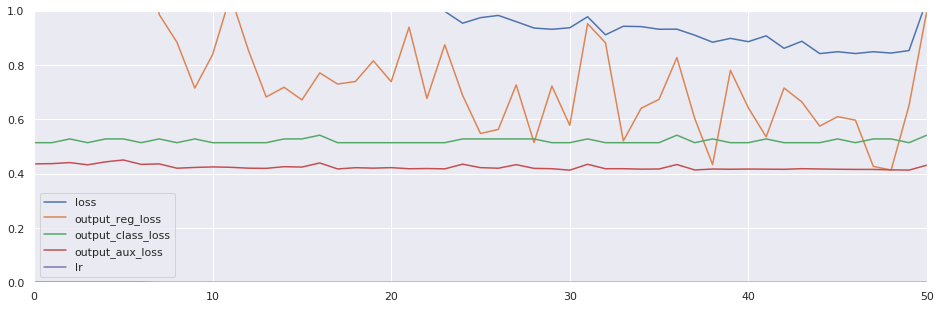

In [125]:
pd.DataFrame(hist.history).plot(figsize=(16,5))
plt.grid(True)
plt.gca().set_xlim(0, 50)
plt.gca().set_ylim(0, 1)